In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/x-ray_dataset1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Dataset/x-ray_dataset1/val/PNEUMONIA/person1593_virus_2767.jpeg
/content/drive/MyDrive/Dataset/x-ray_dataset1/val/PNEUMONIA/person1580_virus_2739.jpeg
/content/drive/MyDrive/Dataset/x-ray_dataset1/val/PNEUMONIA/person1649_bacteria_4378.jpeg
/content/drive/MyDrive/Dataset/x-ray_dataset1/val/PNEUMONIA/person1644_bacteria_4360.jpeg
/content/drive/MyDrive/Dataset/x-ray_dataset1/val/PNEUMONIA/person1740_bacteria_4579.jpeg
/content/drive/MyDrive/Dataset/x-ray_dataset1/val/PNEUMONIA/person1609_virus_2790.jpeg
/content/drive/MyDrive/Dataset/x-ray_dataset1/val/PNEUMONIA/person1598_bacteria_4195.jpeg
/content/drive/MyDrive/Dataset/x-ray_dataset1/val/PNEUMONIA/person1590_virus_2764.jpeg
/content/drive/MyDrive/Dataset/x-ray_dataset1/val/PNEUMONIA/person1628_bacteria_4294.jpeg
/content/drive/MyDrive/Dataset/x-ray_dataset1/val/PNEUMONIA/person1591_bacteria_4177.jpeg
/content/drive/MyDrive/Dataset/x-ray_dataset1/val/PNEUMONIA/p

In [ ]:
import tensorflow.keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2

In [ ]:
mainDIR = os.listdir('/content/drive/MyDrive/Dataset/x-ray_dataset1')
print(mainDIR)

['val', 'train', 'test', 'vgg16Dset1.h5']


In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/drive/MyDrive/Dataset/x-ray_dataset1/train')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


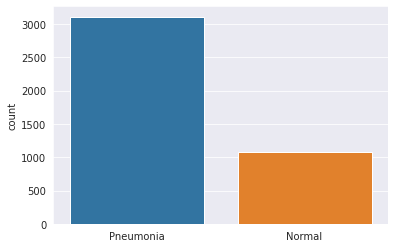

In [ ]:
#data visualization
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

Text(0.5, 1.0, 'NORMAL')

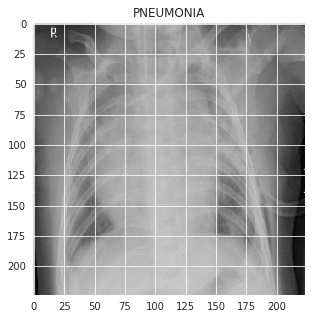

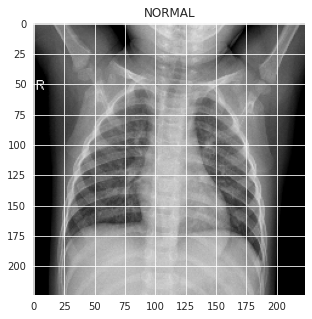

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
#provide data path
IMAGE_SIZE = [224, 224]

train_folder = '/content/drive/MyDrive/Dataset/x-ray_dataset1/train'
test_folder = '/content/drive/MyDrive/Dataset/x-ray_dataset1/test'

In [ ]:
#Here we will be use imagenet weights
vgg = VGG16(weights = 'imagenet',
              include_top = False,
              input_shape = IMAGE_SIZE + [3])

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
#don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
def addTopModel(bottom_model, num_classes, D1=1024, D2=512, D3=256):
    top_model = bottom_model.output
    top_model = Flatten(name= "flatten")(top_model)
    top_model = Dense(D1, activation = "relu")(top_model)
    top_model = Dropout(0.2)(top_model) 
    top_model = Dense(D2, activation = "relu")(top_model)
    top_model = Dropout(0.4)(top_model)
    top_model = Dense(D3, activation = "relu")(top_model)
    top_model = Dropout(0.6)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model) 
    return top_model

num_classes = 2

prediction = addTopModel(vgg, num_classes)

model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [ ]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2,
    rotation_range= 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(
      train_folder,
      target_size=(224, 224),
      batch_size=16,
      class_mode='categorical')

Found 4192 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(
      test_folder,
      target_size=(224, 224),
      batch_size= 32,
      class_mode='categorical')

Found 624 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/content/drive/MyDrive/Dataset/x-ray_dataset1/vgg16Dset1.h5",
                             monitor= "val_loss",
                             mode= "min",
                             save_best_only = True,
                             verbose= 1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5, 
                          verbose = 1,
                          restore_best_weights = True)

#we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [ ]:
nb_train_samples = 4192
nb_validation_samples = 624
epochs = 20
batch_size = 32

history = model.fit_generator(
    training_set,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = test_set,
    validation_steps = nb_validation_samples // batch_size)

model.save("/content/drive/MyDrive/Dataset/x-ray_dataset1/vgg16Dset1.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 1.2210 - accuracy: 0.7476
Epoch 00001: val_loss improved from inf to 0.72559, saving model to /content/drive/MyDrive/Dataset/x-ray_dataset1/vgg16Dset1.h5
131/131 [==============================] - 103s 679ms/step - loss: 1.2210 - accuracy: 0.7476 - val_loss: 0.7256 - val_accuracy: 0.6826
Epoch 2/20
131/131 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.8616
Epoch 00002: val_loss improved from 0.72559 to 0.31590, saving model to /content/drive/MyDrive/Dataset/x-ray_dataset1/vgg16Dset1.h5
131/131 [==============================] - 74s 568ms/step - loss: 0.3229 - accuracy: 0.8616 - val_loss: 0.3159 - val_accuracy: 0.8734
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.8822
Epoch 00003: val_loss improved from 0.31590 to 0.29929, saving model to /content/drive/MyDrive/Dataset/x-ray_dataset1/vgg16Dset1.h5
131/131 [==============================] - 70s 533m

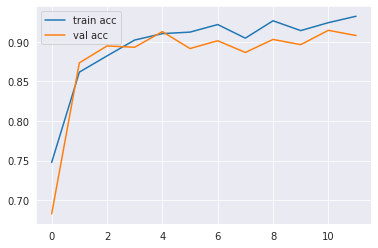

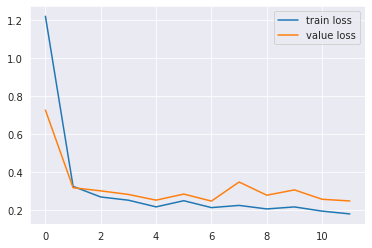

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='value loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [ ]:
history.history

{'accuracy': [0.7476145029067993,
  0.8616412281990051,
  0.882156491279602,
  0.9021946787834167,
  0.9103053212165833,
  0.9122137427330017,
  0.9217557311058044,
  0.9045801758766174,
  0.9265267252922058,
  0.9141221642494202,
  0.9241412281990051,
  0.9322519302368164],
 'loss': [1.220996379852295,
  0.32288476824760437,
  0.26692861318588257,
  0.24996793270111084,
  0.2147892266511917,
  0.2472456693649292,
  0.21090321242809296,
  0.2225133627653122,
  0.20387166738510132,
  0.21448087692260742,
  0.19228902459144592,
  0.177586629986763],
 'val_accuracy': [0.6825658082962036,
  0.8733552694320679,
  0.8947368264198303,
  0.8930920958518982,
  0.9128289222717285,
  0.8914473652839661,
  0.9013158082962036,
  0.8865131735801697,
  0.9029605388641357,
  0.8963815569877625,
  0.9144737124443054,
  0.9078947305679321],
 'val_loss': [0.7255938053131104,
  0.3159039318561554,
  0.2992900013923645,
  0.2803415060043335,
  0.2501889169216156,
  0.2823169231414795,
  0.2452486902475357,

In [ ]:
#For predicting new cases 
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
model = load_model('/content/drive/MyDrive/Dataset/x-ray_dataset1/vgg16Dset1.h5')
img = image.load_img('/content/drive/MyDrive/Dataset/x-ray_dataset1/val/PNEUMONIA/person1399_bacteria_3549.jpeg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
if classes[0][0]>classes[0][1]:
  prediction="Normal"
else:
  prediction="Pneumonia"
print(prediction)

Normal


In [ ]:
test_accu = model.evaluate_generator(test_set,steps=624)
print('The testing accuracy is :',test_accu[1]*100, '%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


The testing accuracy is : 90.22436141967773 %


In [ ]:
#For predicting new cases 
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
model = load_model('/content/drive/MyDrive/phnoD/model.h5')
img = image.load_img('/content/drive/MyDrive/phnoD/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
Normal=classes[0][0]
PNEUMONIA=classes[0][1]
print(f"Normal = {Normal} \n PNEUMONIA= {PNEUMONIA}")

Normal = 0.0 
 PNEUMONIA= 1.0
